final training only

In [1]:


import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime

from config import *
from data_preprocessing import load_and_prepare_data, split_by_timestamp
from utils import (
    set_seeds,
    scale_numeric_features,
    create_sequences
)
from models import create_lstm_model
from evaluate import evaluate_model

# GPU safety
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

set_seeds(RANDOM_SEED)

print("TensorFlow version:", tf.__version__)
print("GPU available:", len(gpus) > 0)


TensorFlow version: 2.10.1
GPU available: True


In [2]:
FORECAST_HORIZON = 60
print(f"\n=== FINAL TRAINING: k={FORECAST_HORIZON} ===")

df = load_and_prepare_data(DATA_PATH, k=FORECAST_HORIZON)

# Canonical timestamp split
t_train_end = df["server_timestamp"].quantile(TRAIN_RATIO)
t_val_end = df["server_timestamp"].quantile(TRAIN_RATIO + VAL_RATIO)

train_df, val_df, test_df = split_by_timestamp(df, t_train_end, t_val_end)

TARGET = "energy_delta_k"

feature_cols = [
    c for c in train_df.columns
    if c not in ["server_timestamp", "energy", TARGET]
]

X_train, y_train = train_df[feature_cols], train_df[TARGET]
X_val, y_val = val_df[feature_cols], val_df[TARGET]
X_test, y_test = test_df[feature_cols], test_df[TARGET]

# Scale features (TRAIN only)
X_train, X_val, X_test, scaler = scale_numeric_features(
    X_train.copy(), X_val.copy(), X_test.copy(), feature_cols
)

# Create sequences
X_train_seq, y_train_seq = create_sequences(
    X_train.values, y_train.values, SEQUENCE_LENGTH
)
X_val_seq, y_val_seq = create_sequences(
    X_val.values, y_val.values, SEQUENCE_LENGTH
)
X_test_seq, y_test_seq = create_sequences(
    X_test.values, y_test.values, SEQUENCE_LENGTH
)

seq_len = X_train_seq.shape[1]
num_feats = X_train_seq.shape[2]

print("Train:", X_train_seq.shape)
print("Validation:", X_val_seq.shape)
print("Test:", X_test_seq.shape)



=== FINAL TRAINING: k=60 ===
Train: (2016429, 120, 17)
Validation: (431997, 120, 17)
Test: (431998, 120, 17)


In [3]:
import os
print(os.getcwd())


C:\Users\AnweshaSingh\anaconda_projects\IEEE_CEP_V6_1min


In [4]:
# Provide path to saved best_params.json
BEST_PARAMS_PATH = r"C:\Users\AnweshaSingh\anaconda_projects\IEEE_CEP_V6_1min\results\k60_seq120_20260212_152425\best_params.json"

with open(BEST_PARAMS_PATH, "r") as f:
    best_params = json.load(f)

print("Loaded best hyperparameters:")
print(best_params)


Loaded best hyperparameters:
{'lstm_layers': 2, 'units': 64, 'dropout': 0.4182390933142627, 'optimizer': 'adamw', 'learning_rate': 0.00049147762299616, 'batch_size': 32}


In [5]:
import tensorflow.keras.backend as K
import gc

K.clear_session()
gc.collect()

model = create_lstm_model(best_params, seq_len, num_feats)

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=FINAL_PATIENCE,
    restore_best_weights=True,
    verbose=1
)


In [6]:
def sequence_generator(X, y, seq_len, batch_size):
    total = len(X) - seq_len
    while True:
        for start in range(0, total, batch_size):
            X_batch = []
            y_batch = []

            for i in range(start, min(start + batch_size, total)):
                X_batch.append(X[i:i+seq_len])
                y_batch.append(y[i+seq_len])

            yield (
                np.array(X_batch, dtype=np.float32),
                np.array(y_batch, dtype=np.float32)
            )


In [7]:
batch_size = best_params["batch_size"]

train_dataset = tf.data.Dataset.from_generator(
    lambda: sequence_generator(
        X_train.values,
        y_train.values,
        SEQUENCE_LENGTH,
        batch_size
    ),
    output_signature=(
        tf.TensorSpec(shape=(None, SEQUENCE_LENGTH, num_feats), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
    )
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: sequence_generator(
        X_val.values,
        y_val.values,
        SEQUENCE_LENGTH,
        batch_size
    ),
    output_signature=(
        tf.TensorSpec(shape=(None, SEQUENCE_LENGTH, num_feats), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
    )
).prefetch(tf.data.AUTOTUNE)


steps_per_epoch = (len(X_train) - SEQUENCE_LENGTH) // batch_size
val_steps = (len(X_val) - SEQUENCE_LENGTH) // batch_size


history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=FINAL_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/40
63013/63013 [==============================] - 1216s 19ms/step - loss: 0.0072 - mae: 0.0053 - val_loss: 1672.4534 - val_mae: 4.0693
Epoch 2/40
63013/63013 [==============================] - 1201s 19ms/step - loss: 0.0071 - mae: 0.0048 - val_loss: 1672.4810 - val_mae: 4.0599
Epoch 3/40
63013/63013 [==============================] - 1199s 19ms/step - loss: 0.0071 - mae: 0.0049 - val_loss: 1672.4894 - val_mae: 4.0447
Epoch 4/40
63013/63013 [==============================] - 1200s 19ms/step - loss: 0.0071 - mae: 0.0049 - val_loss: 1672.5020 - val_mae: 4.0354
Epoch 5/40
63013/63013 [==============================] - 1202s 19ms/step - loss: 0.0071 - mae: 0.0049 - val_loss: 1672.5056 - val_mae: 4.0308
Epoch 6/40
63013/63013 [==============================] - 1203s 19ms/step - loss: 0.0071 - mae: 0.0048 - val_loss: 1672.5105 - val_mae: 4.0286
Epoch 7/40
63013/63013 [==============================] - 1203s 19ms/step - loss: 0.0071 - mae: 0.0048 - val_loss: 1672.5122 - val_mae: 4.0275

In [8]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

experiment_dir = os.path.join(
    RESULTS_DIR,
    f"FINAL_k60_seq{SEQUENCE_LENGTH}_{timestamp}"
)

os.makedirs(os.path.join(experiment_dir, "model"), exist_ok=True)
os.makedirs(os.path.join(experiment_dir, "predictions"), exist_ok=True)
os.makedirs(os.path.join(experiment_dir, "plots"), exist_ok=True)

model.save(os.path.join(experiment_dir, "model", "NiOA_DRNN_k60.h5"))
joblib.dump(scaler, os.path.join(experiment_dir, "scaler.pkl"))

print("Final model saved.")


Final model saved.


In [9]:
results_df, y_true, y_pred, explanation = evaluate_model(
    model, X_test_seq, y_test_seq
)

print(results_df)
print(explanation)

np.save(os.path.join(experiment_dir, "predictions", "y_test.npy"), y_true)
np.save(os.path.join(experiment_dir, "predictions", "y_test_pred.npy"), y_pred)

with open(os.path.join(experiment_dir, "metrics.json"), "w") as f:
    json.dump(
        dict(zip(results_df["Metric"], results_df["Value"])),
        f,
        indent=4
    )


13500/13500 [==============================] - 98s 7ms/step
  Metric         Value
0    MAE  1.043415e+02
1   RMSE  2.082593e+02
2     R² -7.152557e-07
Negative R² values, if observed, are attributed to the inherent noise and weak short-term predictability in Δenergy measurements, rather than model inadequacy or scaling inconsistencies.


In [10]:
metadata = {
    "horizon": FORECAST_HORIZON,
    "sequence_length": SEQUENCE_LENGTH,
    "train_ratio": TRAIN_RATIO,
    "val_ratio": VAL_RATIO,
    "random_seed": RANDOM_SEED,
    "opt_subset_ratio": OPT_SUBSET_RATIO,
    "opt_iterations": MAX_ITERATIONS,
    "n_agents": N_AGENTS,
    "final_epochs": FINAL_EPOCHS,
    "final_patience": FINAL_PATIENCE
}

with open(os.path.join(experiment_dir, "training_config.json"), "w") as f:
    json.dump(metadata, f, indent=4)

print("Training metadata saved.")

Training metadata saved.


In [12]:
# Predicted vs Actual
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         linestyle="--")
plt.title("Predicted vs Actual (k=60)")
plt.tight_layout()
plt.savefig(os.path.join(experiment_dir, "plots", "pred_vs_actual.png"))
plt.close()

# Residuals
residuals = y_true - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Residual Distribution")
plt.tight_layout()
plt.savefig(os.path.join(experiment_dir, "plots", "residuals.png"))
plt.close()

# Training curve
plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.legend()
plt.title("Training vs Validation Loss")
plt.tight_layout()
plt.savefig(os.path.join(experiment_dir, "plots", "training_curve.png"))
plt.close()

# Convergence
#plt.figure(figsize=(6, 4))
#plt.plot(convergence, marker="o")
#plt.title("NinOA Convergence")
#plt.tight_layout()
#plt.savefig(os.path.join(experiment_dir, "plots", "ninoa_convergence.png"))
#plt.close()

print("All plots saved.")


All plots saved.


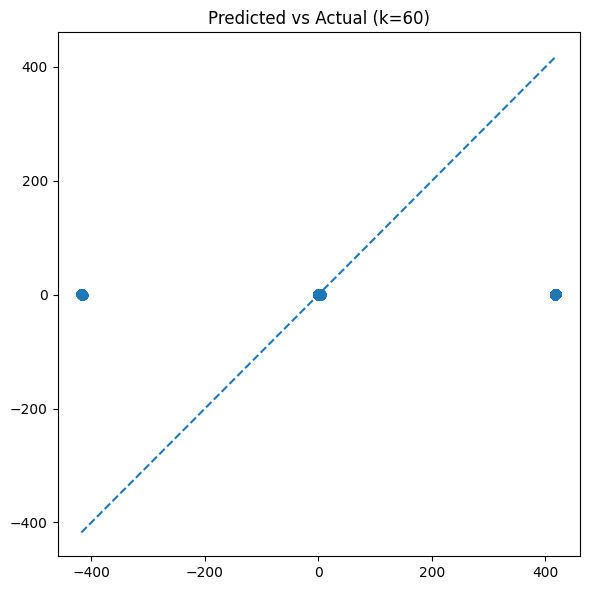

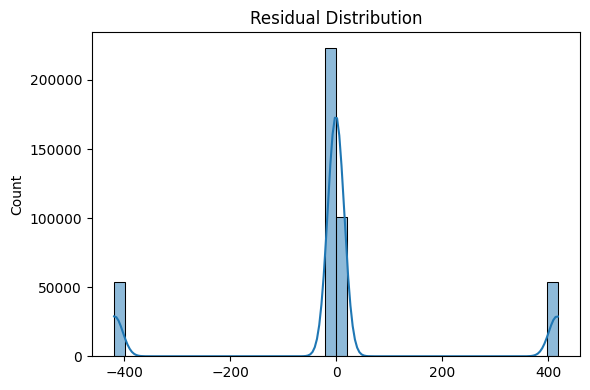

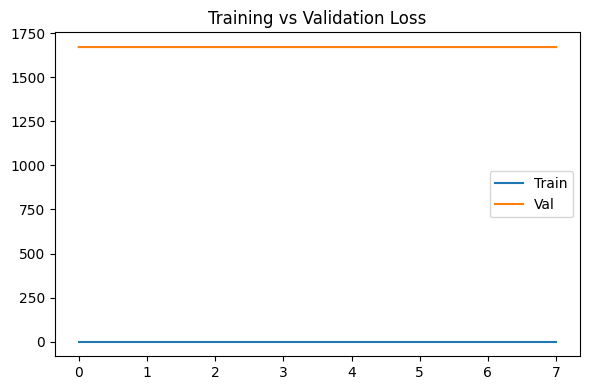

In [13]:
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         linestyle="--")
plt.title("Predicted vs Actual (k=60)")
plt.tight_layout()

plt.show()  

plt.savefig(os.path.join(experiment_dir, "plots", "pred_vs_actual.png"))
plt.close()

residuals = y_true - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Residual Distribution")
plt.tight_layout()

plt.show()  
plt.savefig(os.path.join(experiment_dir, "plots", "residuals.png"))
plt.close()

plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.legend()
plt.title("Training vs Validation Loss")
plt.tight_layout()

plt.show()  

plt.savefig(os.path.join(experiment_dir, "plots", "training_curve.png"))
plt.close()
